# Sensitivity analysis on models governed by stochastic fields :
## Analysis & Validation

- Date: 14.10.20
- Author: K. A. Simady 

##### Aim of the notebook : present the methods already developed as well as a simple example, and compare the already known methods to the ones developed. 
- **Theme :** Sensitivity analysis of models taking as an input scalar random variables, as well as random stochastic fields. 
- **Example :** Model of a beam being supported on both ends and subject to a point force. Five quantities are subject to uncertainties : 
    - The diameter D_ of the section of the beam is varying along a one dimensional field along the axis of the beam. 
    - The Young Modulus E_ is also varying stochastically along the same axis
    - The position of the application point of the force FPos is following a scalar normal law centered on the beams middle point. 
    - The norm of the force vector FNorm is also follwing a scalar normal law centered around 100N 
    - The global densitiy of the beam which is also determined by a scalar normal law centered around the materials real density
- **Method :** Roughly, the method consist in reexpressing the model (which was taking as inputs **Fields** & **Scalars**) as a new model only dependent of a **Scalar vector**. This is made possible through the usage of the **Karhunen-Loeve decomposition**, thanks to which one can freely express a field generated by a stochastic process of known parameters as a vector of scalars. This decomposition is analogous to the **Fourier** decomposition. Once the model is re-expressed a metamodel is built using either krieging or polynomial chaos. Then the sensitivity analysis is done on this metamodel, in hope that it behaves as the real model. This will be tested here.
- **Application :** This method is developed to be used to analyse the model of a aeronautics grade heat exchanger, but this example will not be presented here. 

In [1]:
# Let's first import the necessary modules. 
# Base modules :
import os
from collections.abc import Sequence, Iterable
import numpy as np
import openturns as ot
import pandas as pd
# Phimeca's modules :
import pythontools as pt # tools created for krieging, pce and other stuff... 
# Own modules : 
import KarhunenLoeveFieldSensitivity as klfs # integration of the codes developed ... 
# Example Model :
import PureBeamExample as MODEL # Could be any model really... 


Bad key "text.kerning_factor" on line 4 in
/home/simady/anaconda/envs/stochastic_field_env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


- The inputs to our model are the 5 uncertain variables, which effects we try to measure. As for the Karhunen-Loeve decomposition the parameters of the stochastic process must be known (scale, amplitude, autocorrelation function) we will first define those. 
- Only two of our 5 inputs are stochastic fields, but we need to also express the other ones as fields. To achieve this, we can think about a scalar as the first value of a constant stochastic_field. 

In [2]:
# Let's define a function that transforms a scalar random law and a mesh into a constant stochastic process : 
def distributionOnMesh(distribution, mesh):
    '''Function to transform a scalar distribution into 
    a constant process defined over a mesh
    '''
    basis = ot.Basis([ot.SymbolicFunction(['x'],['1'])])
    distributionOnMesh = ot.FunctionalBasisProcess(distribution, basis, mesh)
    distributionOnMesh.setName(distribution.getName())
    return distributionOnMesh

##### Let's define our processes :
- As only the autocovariance function and the mesh is needed for the **Karhunen Loeve** decomposition, we have no need to neither define our gaussian processes nor to set a trend function. This has some implications :
    - **The trend function was as a constant to represent the mean value of our process. As it is no longer present, in the decomposition, we have to directly add the means inside of our model and consider the inputs as sole perturbations of the mean.**

In [3]:
# Let's first define the mesh, as it is the same for all the processes, random variables and the finite elements of the beam itself. 
dimension = 1
NElem = [100]
mesher = ot.IntervalMesher(NElem)
lowerBound = [0] #mm
upperBound = [1000] #mm
interval = ot.Interval(lowerBound,upperBound)
mesh = mesher.build(interval)
# 100 elements of 10 mm

In [4]:
# First process decomposition : Stochastic young's modulus 
amplitude0 = [50000]*dimension # Mean : 210000 MPaa
scale0 = [300]*dimension 
nu0 = 13/3
model0 = ot.MaternModel(scale0, amplitude0, nu0)
# Karhunen Loeve decomposition of process 
algorithm = ot.KarhunenLoeveP1Algorithm(mesh, model0, 1e-3)
algorithm.run()
resultsE = algorithm.getResult()
resultsE.setName('E_')

In [5]:
# Second process decomposition : Stochastic Diameter
amplitude = [.3]*dimension # Mean 10 mm
scale = [250]*dimension
nu = 13/3
model1 = ot.MaternModel(scale, amplitude, nu)
algorithm = ot.KarhunenLoeveP1Algorithm(mesh, model1, 1e-3)
algorithm.run()
resultsD = algorithm.getResult()
resultsD.setName('D_')

In [6]:
# The three scalar random variables : 
# random variable for the density of the material (kg/m³)
sigma       = 750
RV_Rho = ot.Normal(0, sigma)
RV_Rho.setName('Rho')
# random variable for the position of the force (mm) 
sigma_f      = 50
RV_Fpos = ot.Normal(0, sigma_f)
RV_Fpos.setName('FPos')
# random variable for the norm of the force (N)
sigma_Fnor    = 5.5
RV_Fnorm  = ot.Normal(0, sigma_Fnor)
RV_Fnorm.setName('FNorm')
# Conversion into constant stochastic processes : 
# Then convert the distributions to processes over a mesh
SP_Rho = distributionOnMesh(RV_Rho, mesh)
SP_Fpos = distributionOnMesh(RV_Fpos, mesh)
SP_Fnorm = distributionOnMesh(RV_Fnorm, mesh)

- Now that our three scalar random variables are expressed as stochastic processes we can decompose them using the KL decomposition **BUT** :
    - We shall still not forget to add their means into our model and **we must think to limit the order of decomposition of our process to 1, as we need no more than one scalar variable to express an other scalar.** (Transforms from allmost any law exist into the normal centered law) 

In [7]:
# Decomposition of the process representing the density
algorithm0 = ot.KarhunenLoeveP1Algorithm(mesh, SP_Rho.getCovarianceModel())
algorithm0.setNbModes(1)
algorithm0.run()
resultsRho = algorithm0.getResult()
resultsRho.setName('Rho_')

# Decomposition of the process representing the position of the force
algorithm1 = ot.KarhunenLoeveP1Algorithm(mesh, SP_Fpos.getCovarianceModel())
algorithm1.setNbModes(1)
algorithm1.run()
resultsFpos = algorithm1.getResult()
resultsFpos.setName('Fpos_')

# Decomposition of the process representing the norm of the force
algorithm2 = ot.KarhunenLoeveP1Algorithm(mesh, SP_Fnorm.getCovarianceModel())
algorithm2.setNbModes(1)
algorithm2.run()
resultsFnor = algorithm2.getResult()
resultsFnor.setName('Fnorm_')

#### Once all the processes are defined, created and decomposed thanks to Karhunen Loeve, we use our newly created class **AggregatedKarhunenLoeveResults**. This class is the link between our reduced normal centered law vector, being one dimensional, and our dimension of arbitrary fields and scalars (so either a-dimensional or multi-dimensional). 

In [8]:
listOfKLRes = [resultsE, resultsD, resultsRho, resultsFpos, resultsFnor]
AggregatedKLRes = klfs.AggregatedKarhunenLoeveResults(listOfKLRes)

###### Depending on how our model was defined, some more steps may be performed if necessary. In our case, to initialize our model, we first have to pass it a mesh from which dimensions it builds its finite element representation, entirely based on the mesh on which the processes where defined. Then we differentiate our model into two functions, one that works on multiple inputs with multiprocessing and one only for single evaluations. **This differntation step is optional, only one of the two functions is needed**
- **The functions as well as the aggregated Karhunen Loeve Results object are passed to a other newly defined class: KarhunenLoeveGeneralizedFunctionWrapper :
    - As this class has access to the Karhunen-Loeve decomposition (which is as said the link between our differnt dimensions) and the model to analyse, this wrapper allows us to get a other view of the model, a view where the model is only dependent of a input vector of values following a centered reduced normal law.

In [9]:
# definition of the model :
_MODEL = MODEL.PureBeam(mesh)

# initialization of the function wrapper : 
FUNC = klfs.KarhunenLoeveGeneralizedFunctionWrapper(
                                AggregatedKarhunenLoeveResults = AggregatedKLRes,
                                func        = _MODEL.singleEval, 
                                func_sample = _MODEL.batchEval,
                                n_outputs   = 2) #We have to define the number of elements in the tuple the model returns !!!!!!!!!!!

#### Now that we have defined our model and input parameters we can begin to design our DOE (Design of experiment). We will generate mutiple DOEs, as we want to compare multiple methods together. 
- **As we know that ALL the components of the vector entering into our wrapped functions are following a centered resuced normal law we have different ways of generating our DOE.**
    - First of all we need 3 types of DOEs :
        - One for the krieging with 100 points : This one will be generated with the LHS sampling method. For this generation we do not need any class in particular. 
            - => For this sample we also need the response (or output) of the finite element model (FUNC) 
        - Two for the calculus of the sobol indices. These ones will be much bigger and will only follow a random sampling method. Only one of these samples will be evaluated on the finite element model. The other one will be evaluated on the krieging metamodel to compare the sobol indices in both cases. 
    - As we want to test the inluence of the different parameters having an influence we will prepaper multiple DOEs per type of DOE. :
        - For the first type (the krieging model):
            - one DOE with 50 points following the LHS sampling method    | SEED : 130875 => CALCULUS OF THE FEM MODEL RESPONSE
            - one DOE with 100 points following the LHS sampling method   | SEED : 409484 => CALCULUS OF THE FEM MODEL RESPONSE
            - one DOE with 200 points following the LHS sampling method   | SEED : 224409 => CALCULUS OF THE FEM MODEL RESPONSE

        - For the second and third type (sobol on the fem model):
            - one DOE with 1000 points following a random sampling method | SEED : 248214 => CALUCLUS OF THE FEM MODEL RESPONSE
            - one DOE with 2000 points following a random sampling method | SEED : 720442 => CALUCLUS OF THE FEM MODEL RESPONSE
            - one DOE with 4000 points following a random sampling method | SEED : 109242 => CALUCLUS OF THE FEM MODEL RESPONSE



In [10]:
import functools
import time
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer


# Little helper class for optimized lhs :
@timer
def optimizedLHS(distribution, size, seed):
    ot.RandomGenerator.SetSeed(seed)
    lhs = ot.LHSExperiment(distribution, size, True, True)
    lhs_optimise = ot.SimulatedAnnealingLHS(lhs)
    lhs_sample = lhs_optimise.generate()
    return lhs_sample

@timer
def getSample(distribution, size, seed):
    ot.RandomGenerator.SetSeed(seed)
    sample = distribution.getSample(size)
    sample.setDescription(distribution.getDescription())
    return sample

@timer 
def getSobolExperiment(size, seed):
    ot.RandomGenerator.SetSeed(seed)    
    experiment = klfs.KarhunenLoeveSobolIndicesExperiment(AggregatedKLRes, size)
    sobolExp = experiment.generate()
    return sobolExp

To build our design of experiment, we will need some data about our KL decomposition, namely the order of decomposition and a random normal vector

In [11]:
nModes = AggregatedKLRes.getSizeModes()  # the number of elements in the input vector of our KL wrapped model
randNormVect = ot.ComposedDistribution([ot.Normal()] * nModes)  # 
randNormVect.setDescription(AggregatedKLRes._getModeDescription())
randNormVect

class=ComposedDistribution name=ComposedDistribution dimension=18 copula=class=IndependentCopula name=IndependentCopula dimension=18 marginal[0]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[1]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[2]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[3]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[4]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[5]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[6]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[7]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[8]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[9]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[10]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[11]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[12]=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1] marginal[13]=class=Normal name=Normal dimension=1 mean=

In [12]:
kg_doe50_130875   = optimizedLHS(randNormVect, 50, 130875)
kg_doe100_409484  = optimizedLHS(randNormVect, 100, 409484)
kg_doe200_224409  = optimizedLHS(randNormVect, 200, 224409)
print('First DOE type done\n')

si_doe1000_248214 = getSobolExperiment(1000, 248214)
si_doe2000_720442 = getSobolExperiment(2000, 720442)
si_doe4000_109242 = getSobolExperiment(4000, 109242)
print('Sobol Samples OK.')

valid_doe200_502849 = optimizedLHS(randNormVect, 200, 502849)

Elapsed time: 0.3342 seconds
Elapsed time: 1.4456 seconds
Elapsed time: 3.7693 seconds
First DOE type done

Samples A and B of size 1000 and dimension 18
Experiment of size 7000 and dimension 18
Elapsed time: 0.2131 seconds
Samples A and B of size 2000 and dimension 18
Experiment of size 14000 and dimension 18
Elapsed time: 0.4738 seconds
Samples A and B of size 4000 and dimension 18
Experiment of size 28000 and dimension 18
Elapsed time: 1.2768 seconds
Sobol Samples OK.
Elapsed time: 4.1906 seconds


#### Now that we have defined our design of expriments, we're going to evaluate the model on them, to get it's response. Then we're going to all save into csv files in  a folder, and use these as a basis for our analysis

In [13]:
DOE_names= ['kg_doe50_130875', 'kg_doe100_409484', 'kg_doe200_224409', 'si_doe1000_248214', 'si_doe2000_720442', 'si_doe4000_109242', 'val_doe200_502849']
DOE_resp_names = ['kg_doe50_130875_resp', 'kg_doe100_409484_resp', 'kg_doe200_224409_resp', 'si_doe1000_248214_resp', 'si_doe2000_720442_resp', 'si_doe4000_109242_resp', 'val_doe200_502849_resp']

In [14]:
l_DOEs = [kg_doe50_130875,kg_doe100_409484,kg_doe200_224409,si_doe1000_248214,si_doe2000_720442,si_doe4000_109242, valid_doe200_502849]

In [15]:
folder = './DOE_RESP'
for i, doe in enumerate(l_DOEs):
    if not os.path.isfile(os.path.join(folder,DOE_names[i]+'.csv')):
        resp = FUNC(doe)
        vonMises = ot.Sample(np.array(np.stack([np.squeeze(np.asarray(resp[0][i])) for i in range(len(resp[0]))]))) 
        maxDefl = resp[1]
        doe.exportToCSVFile(os.path.join(folder,DOE_names[i]+'.csv'))
        vonMises.exportToCSVFile(os.path.join(folder,DOE_resp_names[i]+'_VM'+'.csv'))
        maxDefl.exportToCSVFile(os.path.join(folder,DOE_resp_names[i]+'_MD'+'.csv'))

#### Now that we have our designs of experiment, we can begin to create our metamodels. In our case, we will create 3 metamodels, each created from a different (in size and elements) design of experiment. We will then assess the precision of our metamodel in regard to the functions ouput, and further we will look at the sensitivities

In [16]:
# Lets' first load our 3 designs of experiment for the kriging models. 
# input designs : 
doe50_in = pd.read_csv('DOE_RESP/kg_doe50_130875.csv', sep=';')
doe100_in = pd.read_csv('DOE_RESP/kg_doe100_409484.csv', sep=';')
doe200_in = pd.read_csv('DOE_RESP/kg_doe200_224409.csv', sep=';')
# model outputs :
doe50_out_MD = pd.read_csv('DOE_RESP/kg_doe50_130875_resp_MD.csv', sep=';', header=None)
doe50_VM = pd.read_csv('DOE_RESP/kg_doe50_130875_resp_VM.csv', sep=';', header=None)
doe100_out_MD = pd.read_csv('DOE_RESP/kg_doe100_409484_resp_MD.csv', header=None)
doe100_VM = pd.read_csv('DOE_RESP/kg_doe100_409484_resp_VM.csv', sep=';', header=None)
doe200_out_MD = pd.read_csv('DOE_RESP/kg_doe200_224409_resp_MD.csv', sep=';', header=None)
doe200_VM = pd.read_csv('DOE_RESP/kg_doe200_224409_resp_VM.csv', sep=';', header=None)
# validation models : 
doe_vali_200_in = pd.read_csv('DOE_RESP/val_doe200_502849.csv', sep=';')
doe_vali_200_out_MD = pd.read_csv('DOE_RESP/val_doe200_502849_resp_MD.csv', sep=';',header=None)
doe_vali_200_out_VM = pd.read_csv('DOE_RESP/val_doe200_502849_resp_VM.csv', sep=';',header=None)

In [17]:
# KRIGING SAMPLE
    # INPUTS
sample_doe50_in = ot.Sample(doe50_in.values)
sample_doe50_in.setDescription(doe50_in.columns)
sample_doe100_in = ot.Sample(doe100_in.values)
sample_doe100_in.setDescription(doe100_in.columns)
sample_doe200_in = ot.Sample(doe200_in.values)
sample_doe200_in.setDescription(doe200_in.columns)
    # OUTPUTS
sample_doe50_out_MD = ot.Sample(doe50_out_MD.values)
sample_doe50_out_MD.setDescription(ot.Description.BuildDefault(len(doe50_out_MD.columns), 'MD_'))
sample_doe50_VM = ot.Sample(doe50_VM.values)
sample_doe50_VM.setDescription(ot.Description.BuildDefault(len(doe50_VM.columns), 'VM_'))
sample_doe100_out_MD = ot.Sample(doe100_out_MD.values)
sample_doe100_out_MD.setDescription(ot.Description.BuildDefault(len(doe100_out_MD.columns), 'MD_'))
sample_doe100_VM = ot.Sample(doe100_VM.values)
sample_doe100_VM.setDescription(ot.Description.BuildDefault(len(doe100_VM.columns), 'VM_'))
sample_doe200_out_MD = ot.Sample(doe200_out_MD.values)
sample_doe200_out_MD.setDescription(ot.Description.BuildDefault(len(doe200_out_MD.columns), 'MD_'))
sample_doe200_VM = ot.Sample(doe200_VM.values)
sample_doe200_VM.setDescription(ot.Description.BuildDefault(len(doe200_VM.columns), 'VM_'))
# VALIDATION SAMPLE
validation_sample_doe200_in = ot.Sample(doe_vali_200_in.values)
validation_sample_doe200_in.setDescription(doe_vali_200_in.columns)
validation_sample_doe200_out_MD = ot.Sample(doe_vali_200_out_MD.values)
validation_sample_doe200_out_MD.setDescription(ot.Description.BuildDefault(len(doe_vali_200_out_MD.columns), 'MD_'))
validation_sample_doe200_out_VM = ot.Sample(doe_vali_200_out_VM.values)
validation_sample_doe200_out_VM.setDescription(ot.Description.BuildDefault(len(doe_vali_200_out_VM.columns), 'VM_'))
sample_doe50_in.getDescription()

[E_0,E_1,E_2,E_3,E_4,E_5,E_6,D_0,D_1,D_2,D_3,D_4,D_5,D_6,D_7,Rho_0,Fpos_0,Fnorm_0]

## First, let's define a metamodeling class

In [18]:
class metamodeling_kriging : 
    def __init__(self, inSample, outSample, **kwargs):
        self.input_sample = inSample
        self.output_sample = outSample
        self.__default_kriging__ = None
        self.__kriging_theta__ = None
        self.__kriging_results__ = None
        self.__kriging_metamodel__ = None
        self.__size_multistart__ = kwargs['size_multistart'] if 'size_multistart' in kwargs else 5
        self.__lb__ = kwargs['lower_bound'] if 'lower_bound' in kwargs else None
        self.__ub__ = kwargs['upper_bound'] if 'upper_bound' in kwargs else None
        self.__optim_type__ = kwargs['optim_type'] if 'optim_type' in kwargs else 'best_start'
        self.validation_results = __validation_results__() 
        
    def _build_default(self):
        self.__default_kriging__ = pt.build_default_kriging_algo(
                                    input_sample  = self.input_sample,
                                    output_sample = self.output_sample, 
                                    basis         = None,
                                    covariance_model = None,
                                    noise         = None)
        
    def _estimate_theta(self):
        self.__kriging_theta__ = pt.estimate_kriging_theta(
                            algo_kriging = self.__default_kriging__,
                            lower_bound = self.__lb__,
                            upper_bound = self.__ub__,
                            size        = self.__size_multistart__,
                            optim_type  = self.__optim_type__)
    
    def _get_results_metamodel(self):
        if isinstance(self.__kriging_theta__,(Sequence,Iterable, list)):
            self.__kriging_results__ = [_kt.getResult() for _kt in self.__kriging_theta__]
            self.__kriging_metamodel__ = [_km.getMetaMoel() for _km in self.__kriging_results__]
        else :
            self.__kriging_results__ = self.__kriging_theta__.getResult()
            self.__kriging_metamodel__ = self.__kriging_results__.getMetaModel()
                
    def run(self):
        self._build_default()
        self._estimate_theta()
        self._get_results_metamodel()
        print('Done !')
        
    def getKrigingResult(self):
        return self.__kriging_results__
        
    def getKrigingMetaModel(self):
        return self.__kriging_metamodel__
    
    def _check_clean_nans(self, sampleIn,sampleOut):
        whereNan = list(set(np.argwhere(np.isnan(sampleOut))))
        print('NaN values found at index:',whereNan)
        [(sampleOut.erase(int(val)), sampleIn.erase(int(val))) for val in whereNan]
        
    def getMetaModelValidation(self, sample_in_validation, sample_out_validation):
        assert self.__kriging_metamodel__ is not None, "Please first run calculus"
        assert len(sample_in_validation) == len(sample_out_validation)
        self._check_clean_nans(sample_in_validation, sample_out_validation)
        if isinstance(self.__kriging_metamodel__,(Sequence,Iterable, list)):
            for i, model in enumerate(self.__kriging_metamodel__):
                validation = ot.MetaModelValidation(sample_in_validation, 
                                                    sample_out_validation[:,i],
                                                    self.__kriging_metamodel__[i])
                R2 = validation.computePredictivityFactor()
                residual = validation.getResidualSample()
                graph = validation.drawValidation()
                self.validation_results.addGraph(graph)
                self.validation_results.addR2(R2)
                self.validation_results.addResidual(residual)
        else : 
            validation = ot.MetaModelValidation(sample_in_validation, 
                                                sample_out_validation,
                                                self.__kriging_metamodel__)
            R2 = validation.computePredictivityFactor()
            residual = validation.getResidualSample()
            graph = validation.drawValidation()
            self.validation_results.addGraph(graph)
            self.validation_results.addR2(R2)
            self.validation_results.addResidual(residual)
                
class __validation_results__(object) :
    def __init__(self): 
        self.__R2__ = []
        self.__residuals__ = []
        self.__graphs__ = []

    def addGraph(self, graph):
        self.__graphs__.append(graph)

    def addR2(self, R2):
        self.__R2__.append(R2)

    def addResidual(self, residual):
        self.__residuals__.append(residual)

    def getGraphs(self):
        for graph in self.__graphs__ :
            ot.Show(graph)

    def getResiduals(self):
        theGraph = ot.Graph('Residuals','varying dimension','residual',True,'')
        theCurve = ot.Curve(list(range(len(self.__residuals__))),
                            self.__residuals__, 'residuals')
        theGraph.add(theCurve)
        ot.Show(theGraph)

    def getR2s(self):
        theGraph = ot.Graph('R2','varying dimension','residual',True,'')
        theCurve = ot.Curve(list(range(len(self.__R2__))),
                            self.__R2__, 'R2')
        theGraph.add(theCurve)
        ot.Show(theGraph)

#### First metamodel, DOE : LHS 50  ==> Max Deflection

In [19]:
kriging_doe_50_MD = metamodeling_kriging(sample_doe50_in, sample_doe50_out_MD,optim_type='multi_start', size_multistart = 10)
kriging_doe_50_MD.run()

Done !


###### For validation, we are going to use one of the samples intended for the sobol indices calculus. by the way, we are only going to use the 2/7 th of the samples (as we have samples A, B, and then 5 combinations of those.)

In [20]:
# validation_sample_doe2000_in | validation_sample_doe2000_out_MD | validation_sample_doe2000_out_VM
kriging_doe_50_MD.getMetaModelValidation(validation_sample_doe200_in, validation_sample_doe200_out_MD)


NaN values found at index: []


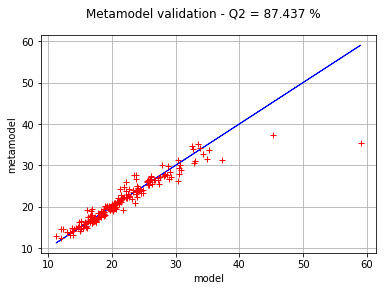

In [21]:
kriging_doe_50_MD.validation_results.getGraphs()

###### As we see, the results here are not so horrible ...

#### Second metamodel, DOE : LHS 100  ==> Max Deflection

In [22]:
kriging_doe_100_MD = metamodeling_kriging(sample_doe100_in, 
                                        sample_doe100_out_MD, 
                                        optim_type='best_start',
                                        size_multistart = 100,
                                        lower_bound = None,
                                        upper_bound = None)
kriging_doe_100_MD.run()

Done !


In [23]:
kriging_doe_100_MD.getMetaModelValidation(validation_sample_doe200_in, validation_sample_doe200_out_MD)


NaN values found at index: []


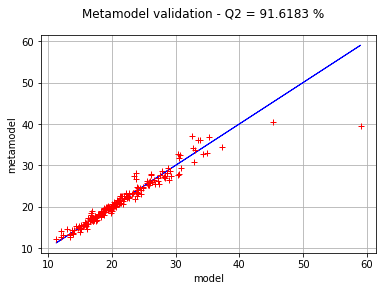

In [24]:
kriging_doe_100_MD.validation_results.getGraphs()

###### Still nothing conclusive ...

#### Third metamodel, DOE : LHS 200  ==> Max Deflection

In [25]:
kriging_doe_200_MD = metamodeling_kriging(sample_doe200_in, 
                                        sample_doe200_out_MD, 
                                        optim_type='best_start',
                                        size_multistart = 100,
                                        lower_bound = None,
                                        upper_bound = None)
kriging_doe_200_MD.run()

Done !


In [26]:
kriging_doe_200_MD.getMetaModelValidation(validation_sample_doe200_in, validation_sample_doe200_out_MD)


NaN values found at index: []


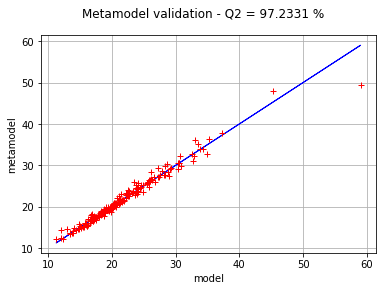

In [27]:
kriging_doe_200_MD.validation_results.getGraphs()

## Comparison of the sensitivity analysis parts. Let's do the sensitivty analysis of the 3 metamodels.

We will first have to load the sample intended to the calculus of the sobol indices, in hope we will find no nan. 

In [28]:
si_2000_in = pd.read_csv('DOE_RESP/si_doe2000_720442.csv', sep=';')
si_2000_out_MD = pd.read_csv('DOE_RESP/si_doe2000_720442_resp_MD.csv', sep=';',header=None)
si_2000_out_VM = pd.read_csv('DOE_RESP/si_doe2000_720442_resp_VM.csv', sep=';',header=None)
#Samples
sample_si_2000_in = ot.Sample(si_2000_in.values)
sample_si_2000_in.setDescription(si_2000_in.columns)

sample_si_2000_out_MD = ot.Sample(si_2000_out_MD.values)
sample_si_2000_out_MD.setDescription(ot.Description.BuildDefault(len(si_2000_out_MD.columns), 'MD_'))

sample_si_2000_out_VM = ot.Sample(si_2000_out_VM.values)
sample_si_2000_out_VM.setDescription(ot.Description.BuildDefault(len(si_2000_out_VM.columns), 'VM_'))

In [29]:
sensitivityAnalysis_REAL_MODEL = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_REAL_MODEL.setDesign(sample_si_2000_in, sample_si_2000_out_MD, 2000)
sensitivityAnalysis_REAL_MODEL.setEstimator(ot.SaltelliSensitivityAlgorithm())

if you also pass the data to compute it
Otherwise, the behavior will be unreliable
There are 5 indices to get for 1 outputs with dimensions 1 each.
SobolIndicesName ['E_', 'D_', 'Rho_', 'Fpos_', 'Fnorm_']


In [30]:
sensitivityAnalysis_REAL_MODEL.getFirstOrderIndices()[0]

TypeError: Object passed as argument is not convertible to a Sample

In [ ]:
sensitivityAnalysis_REAL_MODEL.getTotalOrderIndices()[0]

In [ ]:
sensitivityAnalysis_REAL_MODEL.getConfidenceLevel()[0]